# Insiders Clustering Project

# 0.0 General Area

## 0.1 Imports

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import inflection
import warnings
import re

from matplotlib          import pyplot        as plt
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from sklearn             import preprocessing as pp

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly              import express as px

import umap.umap_ as umap

## 0.2 Support Functions

In [2]:
# data description functions
def numerical_attributes( df ):
    df_num_attributes = df.select_dtypes( include=['int64', 'float64'] )

    # Central Tendency - mean, median
    df_mean   = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
    df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T
    
    # Dispersion - min, max, range, std, skew, kurtosis
    df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
    df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
    df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
    df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
    df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
    df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T
    
    # concatenate dataframes
    df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
    df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
    df_numerical
    
    return df_numerical

def categorical_attributes( df ):
    df_categorical = df.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

    return df_categorical

# data cleaning functions
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    df = df.rename( columns = {'customer' : 'customer_id' } )

    return df

# feature engineering functions
def feature_creation( df ):
    # creating gross revenue
    df['gross_revenue'] = df['quantity'] * df['unit_price']    
    
    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()
warnings.filterwarnings( 'ignore' )

## 0.3 Load Data

In [3]:
df_raw = pd.read_csv( '../data/Ecommerce.csv', low_memory=False, encoding='latin1')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [5]:
print(f'Number of rows: { df1.shape[0] } ')
print(f'Number of cols: { df1.shape[1] } ')

Number of rows: 541909 
Number of cols: 9 


## 1.2 List Data Types

In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Unnamed: 8     float64
dtype: object

## 1.3 Descriptive Statistics

In [7]:
# identify and separate numerical and categorical attrributes
df_numerical   = numerical_attributes( df1 )
df_categorical = categorical_attributes( df1 )

### 1.3.1 Numerical Attributes

In [8]:
df_numerical.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,UnitPrice,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,CustomerID,12346.00,18287.0,5941.00,15287.690570,NaN,1713.598197,0.029835,-1.179982
3,Unnamed: 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.2 Categorical Attributes

In [9]:
df_categorical.head()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,29-Nov-16,United Kingdom
1,536365,71053,WHITE METAL LANTERN,29-Nov-16,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,29-Nov-16,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,29-Nov-16,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,29-Nov-16,United Kingdom


# 2.0 Data Cleaning

In [10]:
df2 = df1.copy()

## 2.1 Rename Columns

In [11]:
df2 = rename_columns( df2 )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,unnamed:8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


## 2.2 Drop Columns

In [12]:
df2 = df2.drop( 'unnamed:8', axis=1 )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 2.3 Check N/A

In [13]:
# number of rows with NA values by column
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Unnamed: 8     541909
dtype: int64

## 2.4 Fillout N/A

In [14]:
#df2['description'].fillna( 'Undefined', inplace=True )
#df2['customer'].fillna( 10000, inplace=True )

## 2.5 Drop N/A Values

In [15]:
df2 = df2.dropna( subset = ['description', 'customer_id'] )

print(f'Removed data : { round( 1 - ( df2.shape[0] / df_raw.shape[0] ), 2) } ') 
print(f'Number of rows Updated: { df2.shape[0] } ')

Removed data : 0.25 
Number of rows Updated: 406829 


## 2.6 Change Data Types

In [16]:
df2['invoice_date'] = pd.to_datetime( df2['invoice_date'] )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## 2.7 Remove Rows

### invoice_no

In [17]:
# identify invoice_no with letters
index = df2['invoice_no'].apply( lambda x : bool( re.search( '[^0-9]+', x ) ) )
df_letter_invoices =  df2.loc[ index, :] 
df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548.0,United Kingdom


### stock_code

In [18]:
# identify stock_code with only letters
index = df2['stock_code'].apply( lambda x : bool( re.search( '^[a-zA-Z]+$', x ) ) )
df_letter_stock_code = df2.loc[ index, :] 

list_stock_code = df_letter_stock_code['stock_code'].unique()
print(f'Rows removed: { len( df2[ df2["stock_code"].isin( list_stock_code ) ] ) } ' )

df2 = df2[ ~df2['stock_code'].isin( list_stock_code ) ]

Rows removed: 1774 


In [19]:
list_stock_code = df_letter_stock_code['stock_code'].unique()
print(f'Rows removed: { len( df2[ df2["stock_code"].isin( list_stock_code ) ] ) } ' )

df2 = df2[ ~df2['stock_code'].isin( list_stock_code ) ]

Rows removed: 0 


### unit_price

In [20]:
# removing rows when unit_price < 0.04
print(f'Rows removed: { len( df2[ df2["unit_price"] < 0.04] ) } ' )
df2 = df2[ df2['unit_price'] >= 0.04]

Rows removed: 35 


### country

In [21]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [22]:
# removing rows where are no contries
print(f'Rows removed: { len( df2[ df2["country"].isin( ["European Community", "Unspecified"] ) ] ) } ' )
df2 = df2[ ~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

Rows removed: 302 


## 2.8 Separate original dataset in two: purchases and returns

In [23]:
df2_returns   = df2[ df2['quantity'] < 0]
df2_purchases = df2[ df2['quantity'] > 0]

# 3.0 Feature Engineering

In [24]:
df3 = df2_purchases.copy()

## 3.1 Feature Creation

In [25]:
def feature_creation( df ):
    # creating gross revenue
    df['gross_revenue'] = df['quantity'] * df['unit_price']    

    # creating customer dataframe
    df_customer = df.drop( columns= ['invoice_no', 'stock_code', 'description', 'quantity', 
                                      'invoice_date', 'unit_price', 'country', 'gross_revenue'], axis=1).drop_duplicates( ignore_index=True )

    # creating customer monetary dataframe - amount of purchases
    df_monetary = df[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

    # creating customer frequency dataframe - number of purchases
    df_frequency = df[['customer_id', 'invoice_no']].groupby('customer_id').nunique().reset_index()

    # creating customer recency dataframe - number of days since last purchase
    max_invoice_date = df['invoice_date'].max()

    df_recency = df[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
    df_recency['recency_days'] =  ( max_invoice_date - df_recency['invoice_date'] ).dt.days
    df_recency = df_recency.drop( 'invoice_date', axis=1 )

    # creating average customer ticket dataframe
    df_avg_ticket = df[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={ 'gross_revenue' : 'avg_ticket' } )

    # merging customer dataframes
    df_customer = pd.merge( df_customer, df_recency,    how='inner', on='customer_id' )
    df_customer = pd.merge( df_customer, df_frequency,  how='inner', on='customer_id' )
    df_customer = pd.merge( df_customer, df_monetary,   how='inner', on='customer_id' )
    df_customer = pd.merge( df_customer, df_avg_ticket, how='inner', on='customer_id' )

    return df_customer
                        
        

In [26]:
df3 = feature_creation( df3 )
df3.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket
0,17850.0,372,34,5391.21,18.152222
1,13047.0,56,9,3232.59,18.904035
2,12583.0,2,15,6705.38,28.902500
3,13748.0,95,5,948.25,33.866071
4,15100.0,333,3,876.00,292.000000


# 4.0 Exploratory Data Analysis

In [27]:
df4 = df3.copy()

# 5.0 Data Preparation

In [28]:
df5 = df4.copy()

## 5.1 Standard Scaler

In [29]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days']  = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no']    = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket']    = ss.fit_transform( df5[['avg_ticket']] )

# 6.0 Feature Selection

In [30]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning

In [31]:
df7 = df6.copy()

X = df7.drop( columns='customer_id' )
X.head()


,recency_days,invoice_no,gross_revenue,avg_ticket
0,2.791504,3.889207,0.377179,-0.033935
1,-0.360996,0.620902,0.135378,-0.033423
2,-0.899714,1.405296,0.524388,-0.026618
3,0.028079,0.097974,-0.120506,-0.023240
4,2.402430,-0.163491,-0.128600,0.152447


## 7.1 Within-Cluster Sum of Square (WSS)

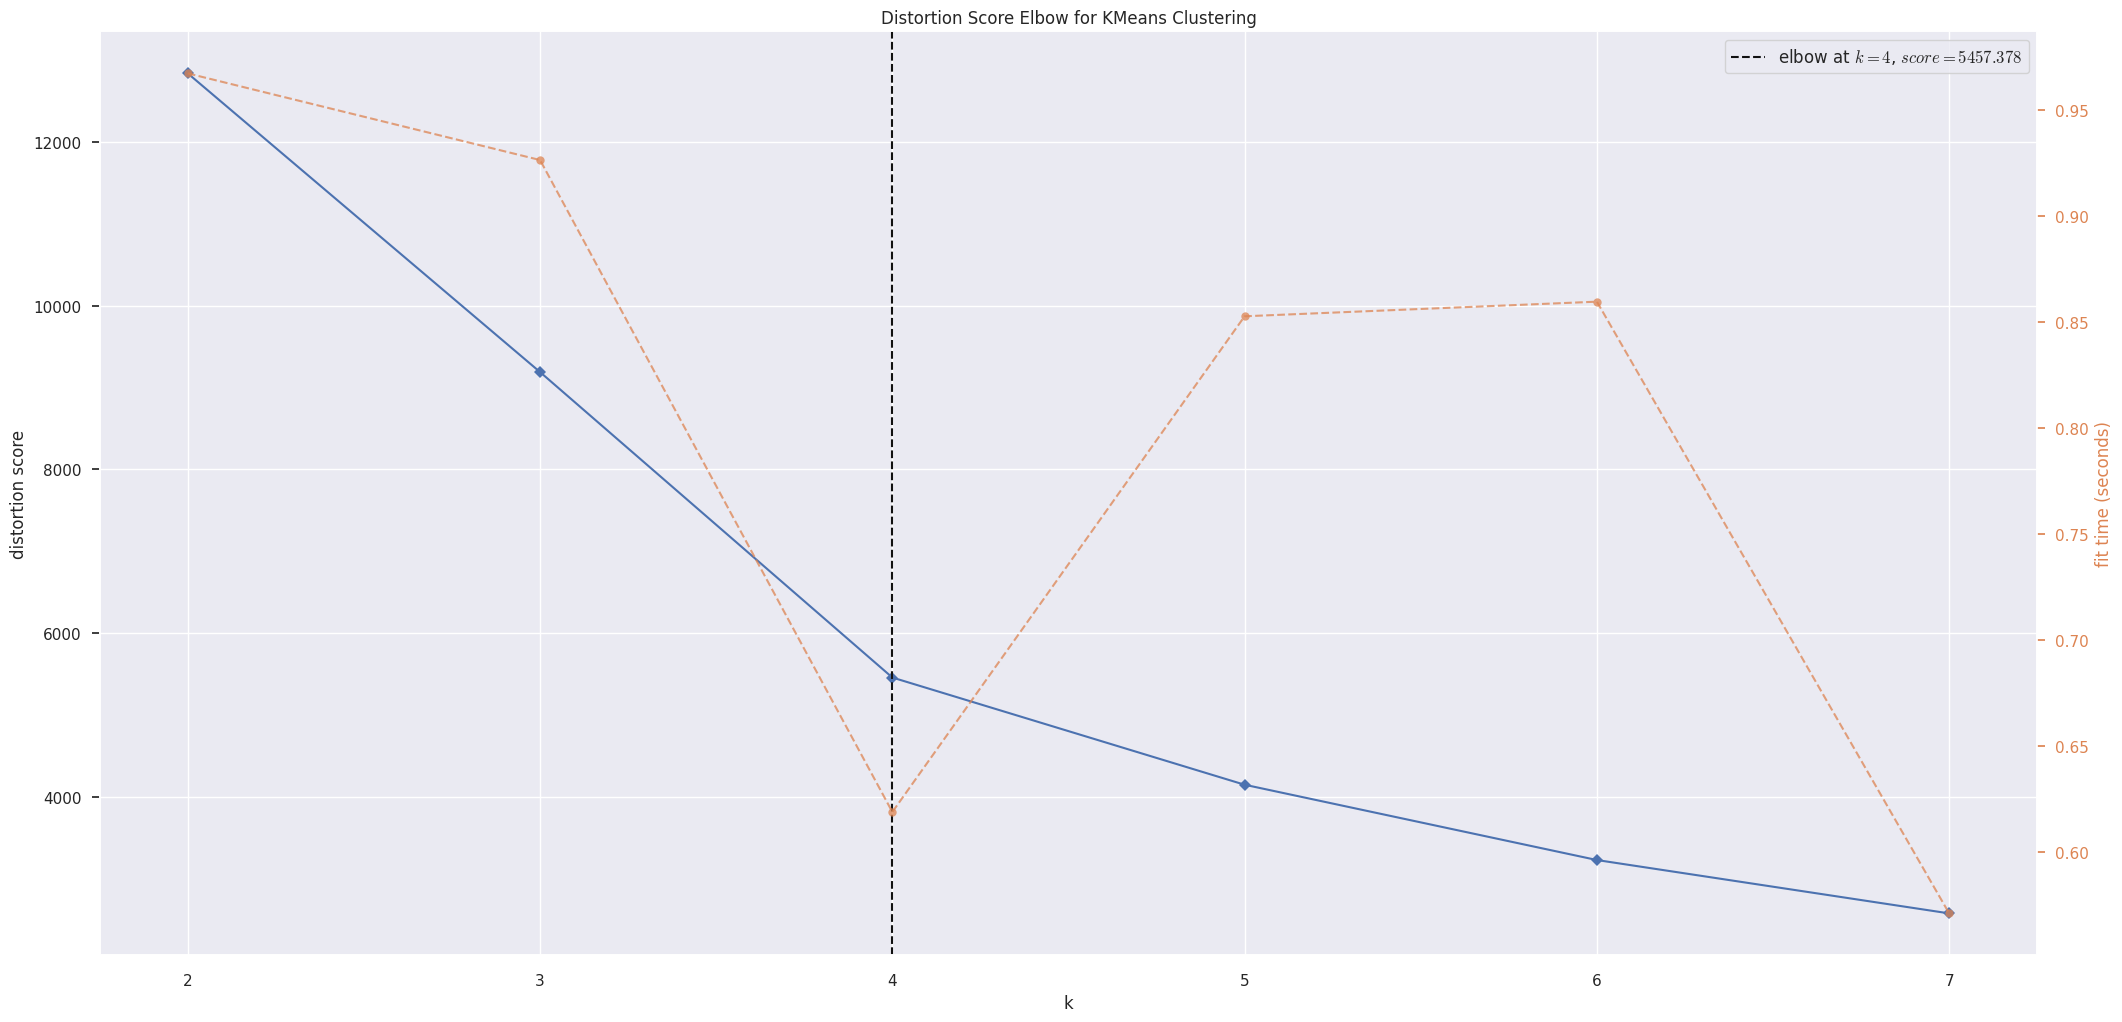

In [32]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timing=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Score

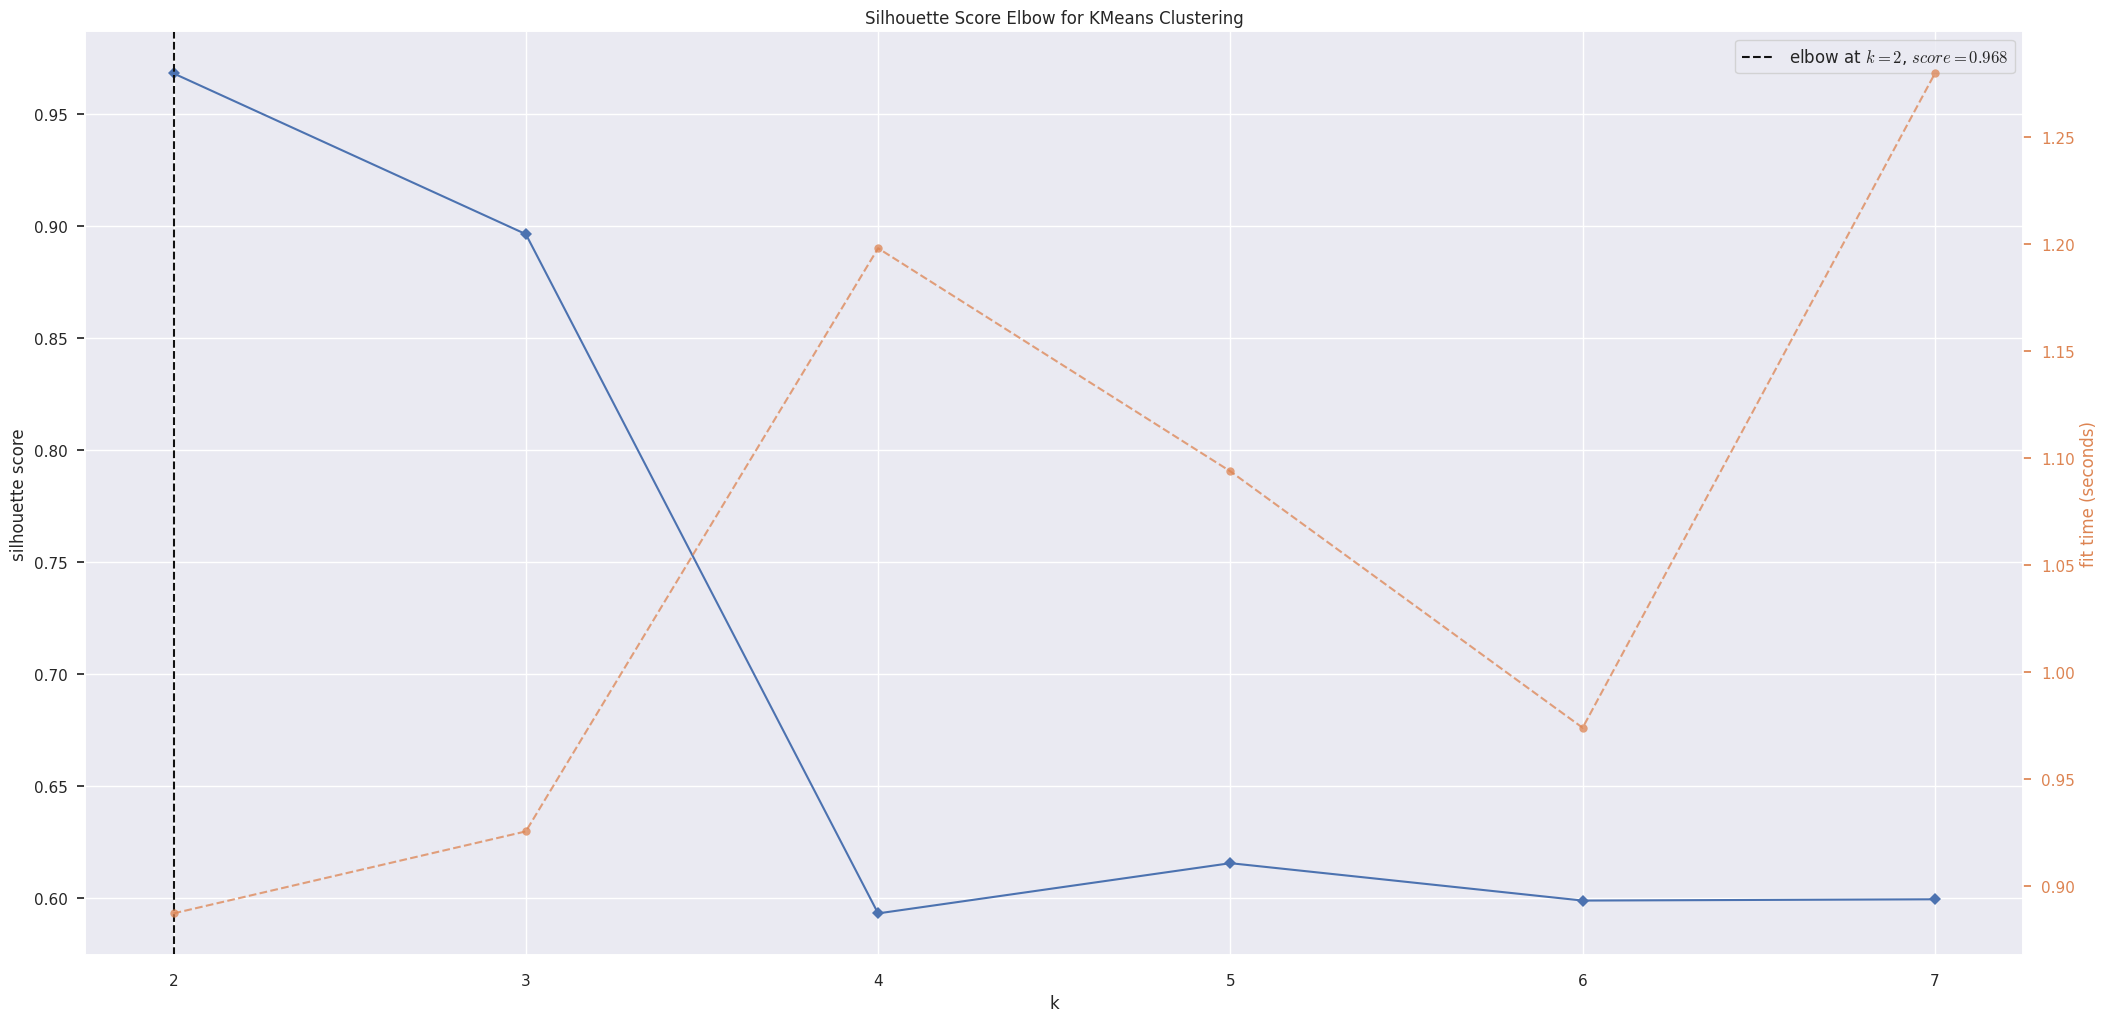

In [33]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timing=False )
kmeans.fit( X )
kmeans.show();

## 7.3 Silhouette Analysis

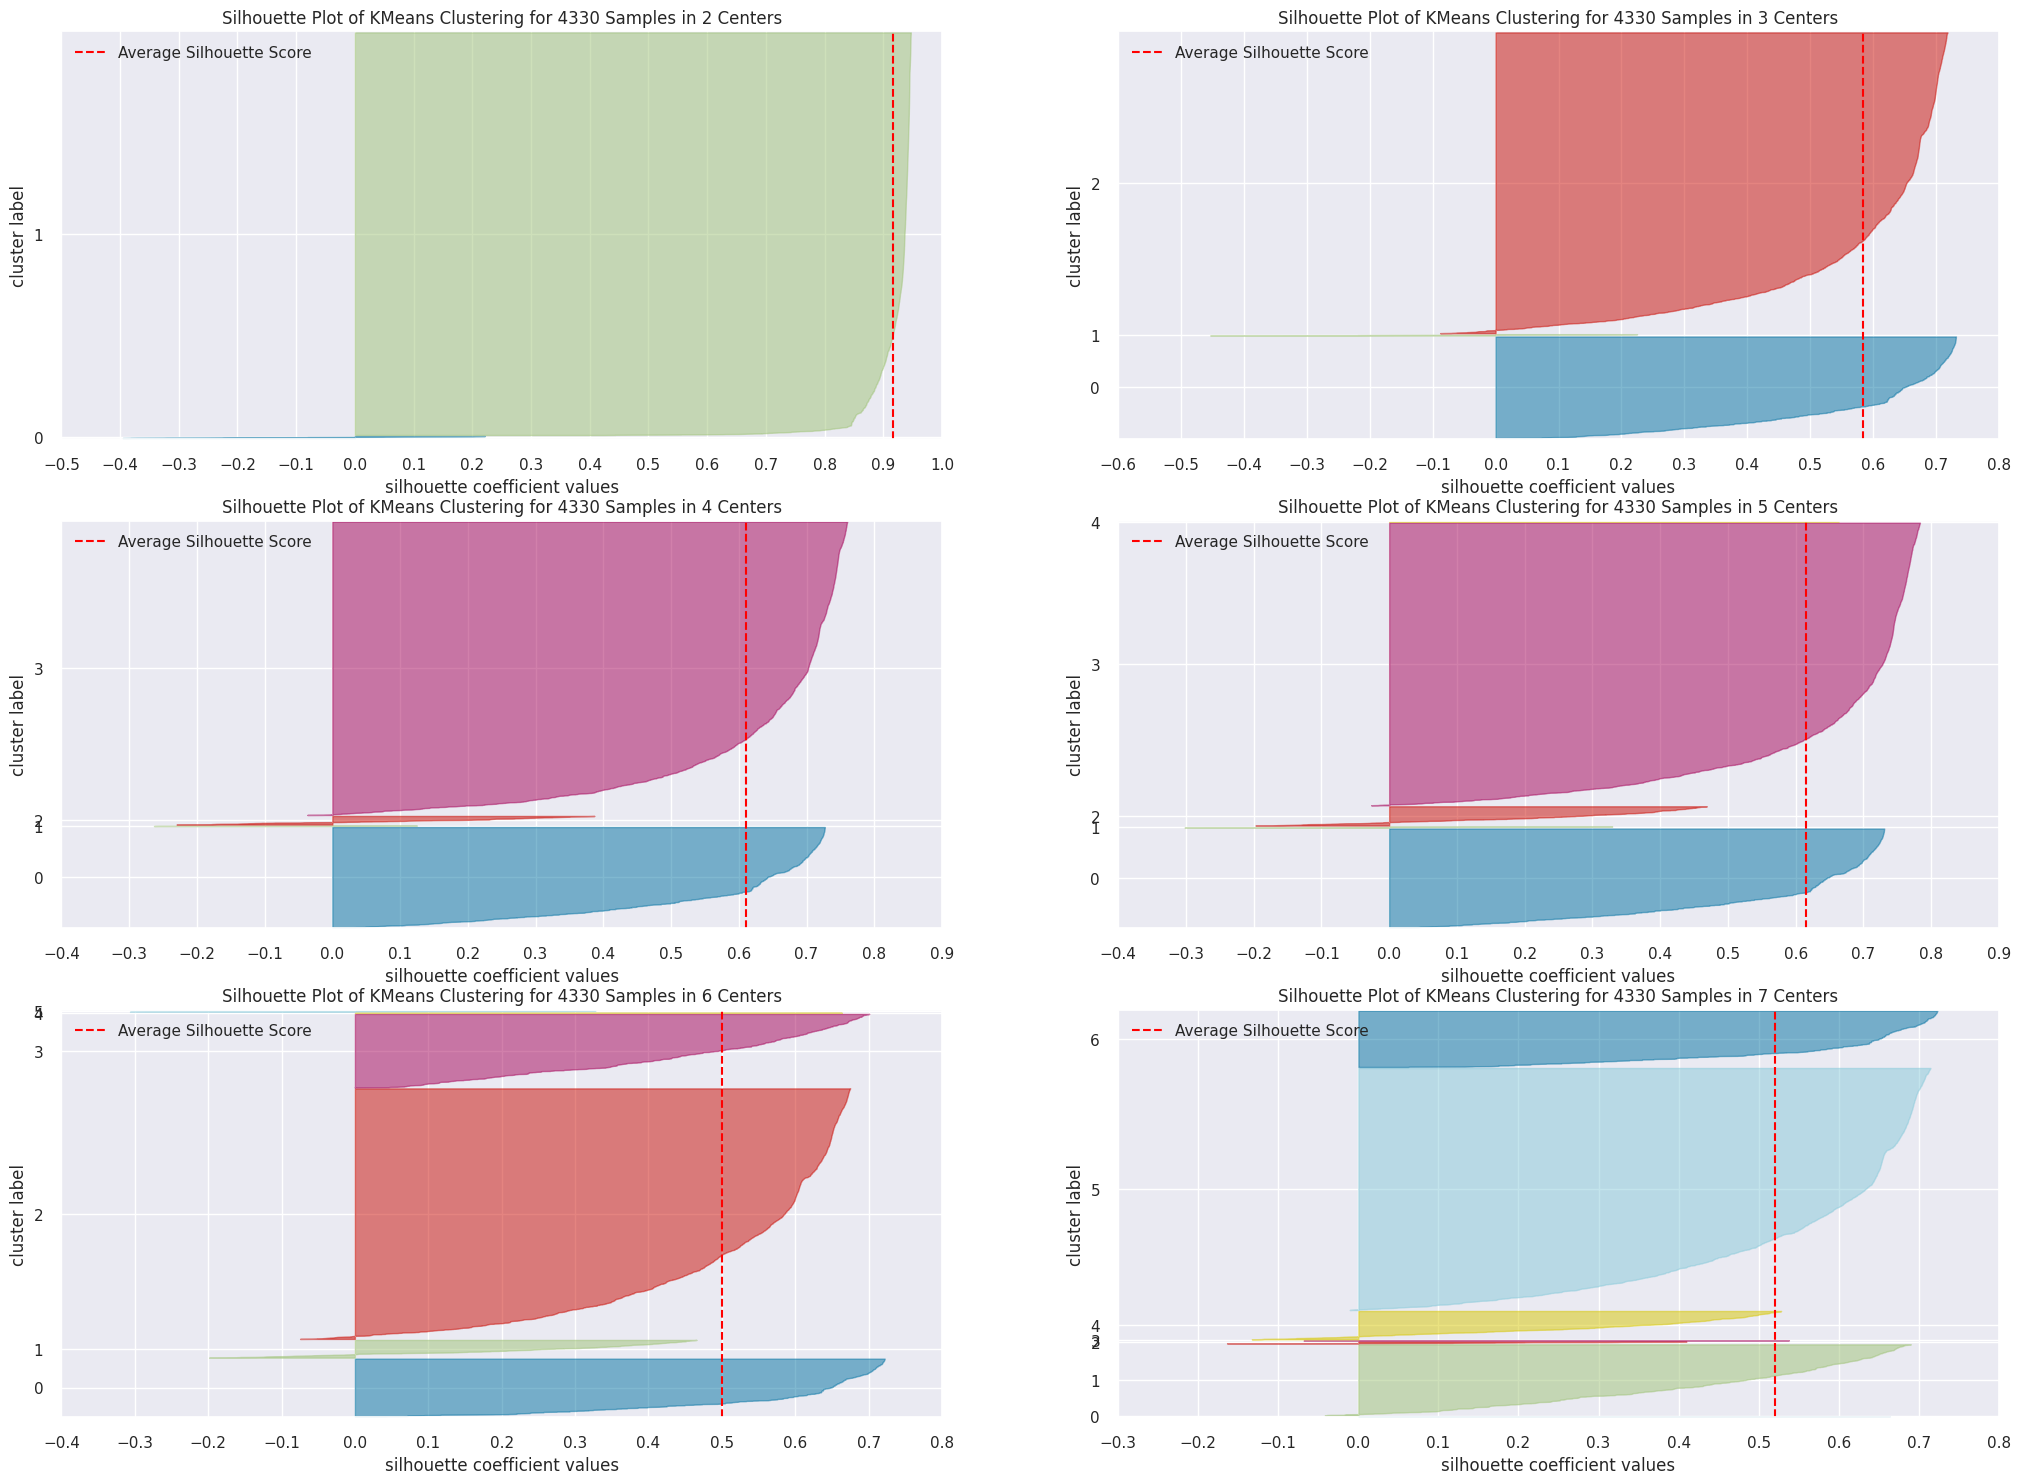

In [34]:
clusters = [2, 3, 4, 5, 6, 7]
fig, axes = plt.subplots(3, 2, figsize=(25, 18) )

for k in clusters:
    q, mod = divmod(k, 2)
    
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42 )
    visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick', ax=axes[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model Training

In [35]:
df8 = df7.copy()

## 8.1 K-Means

In [36]:
# model definition
k=5
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model traning
kmeans.fit( X )

# clustering
labels = kmeans.labels_


## 8.2 Cluster Validation

In [37]:
# WSS - Within Cluster Sum of Square
print(f'WSS : { kmeans.inertia_ } ' )

## SS - Silhouette Score
print(f'SS : { m.silhouette_score( X, labels, metric="euclidean" ) } ' )

WSS : 4147.156605086318 
SS : 0.6155649258613344 


# 9.0 Cluster Analysis

In [38]:
df9 = df8.copy()

df9['cluster'] = labels
df9.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,cluster
0,17850.0,2.791504,3.889207,0.377179,-0.033935,2
1,13047.0,-0.360996,0.620902,0.135378,-0.033423,3
2,12583.0,-0.899714,1.405296,0.524388,-0.026618,2
3,13748.0,0.028079,0.097974,-0.120506,-0.023240,3
4,15100.0,2.402430,-0.163491,-0.128600,0.152447,0


## 9.1 Visualization Inspection

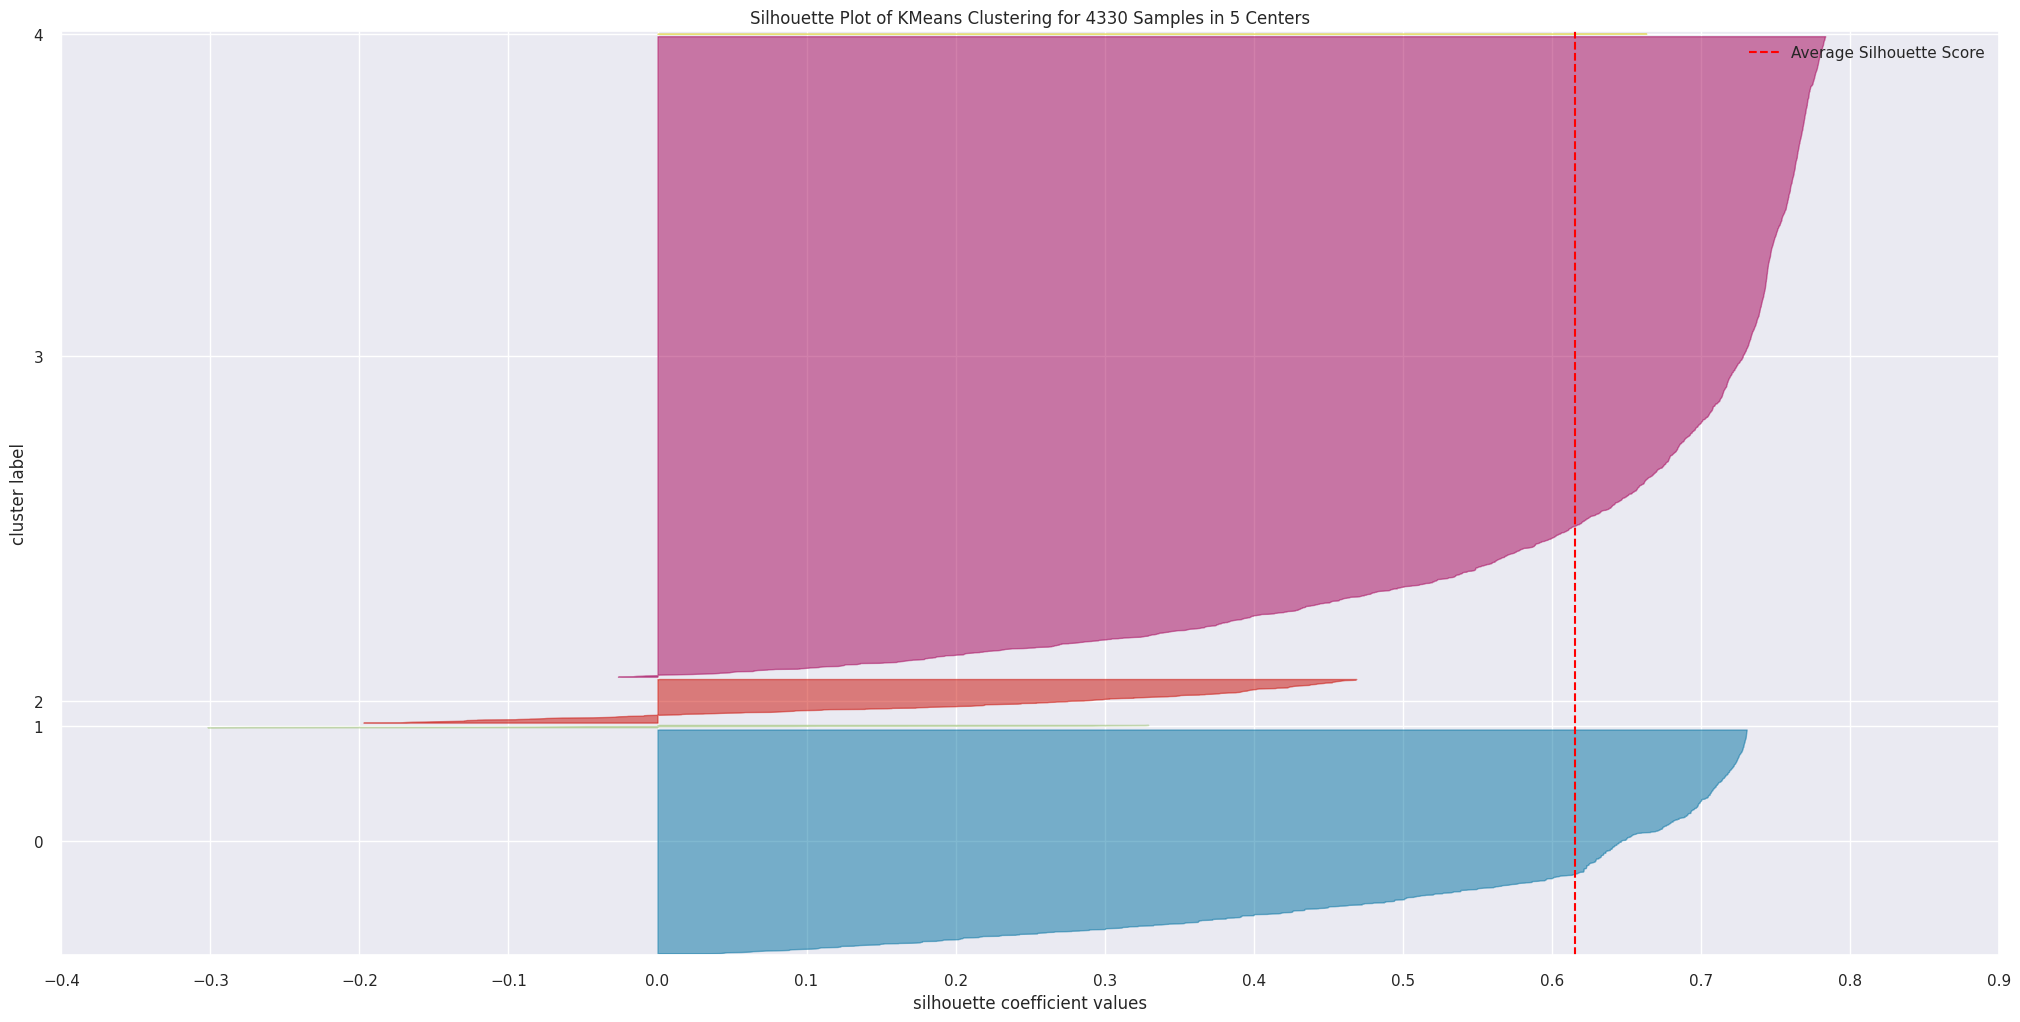

In [39]:
#fig = px.scatter_3d( df10, x='recency_days', y='purchase_frequency', z='gross_revenue', color='cluster' )
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors = 'yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 9.2 2D Plot

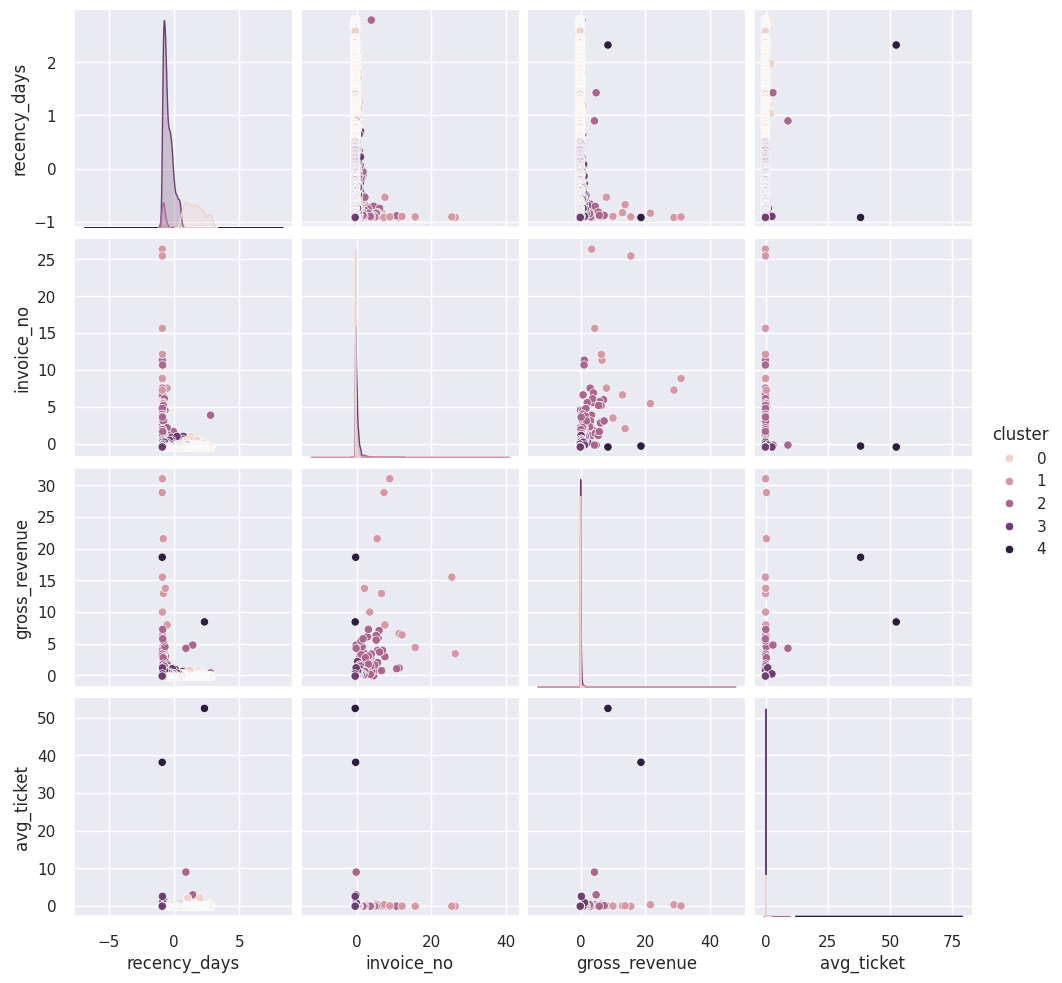

In [40]:
df_viz = df9.drop( 'customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster');

## 9.3 UMAP

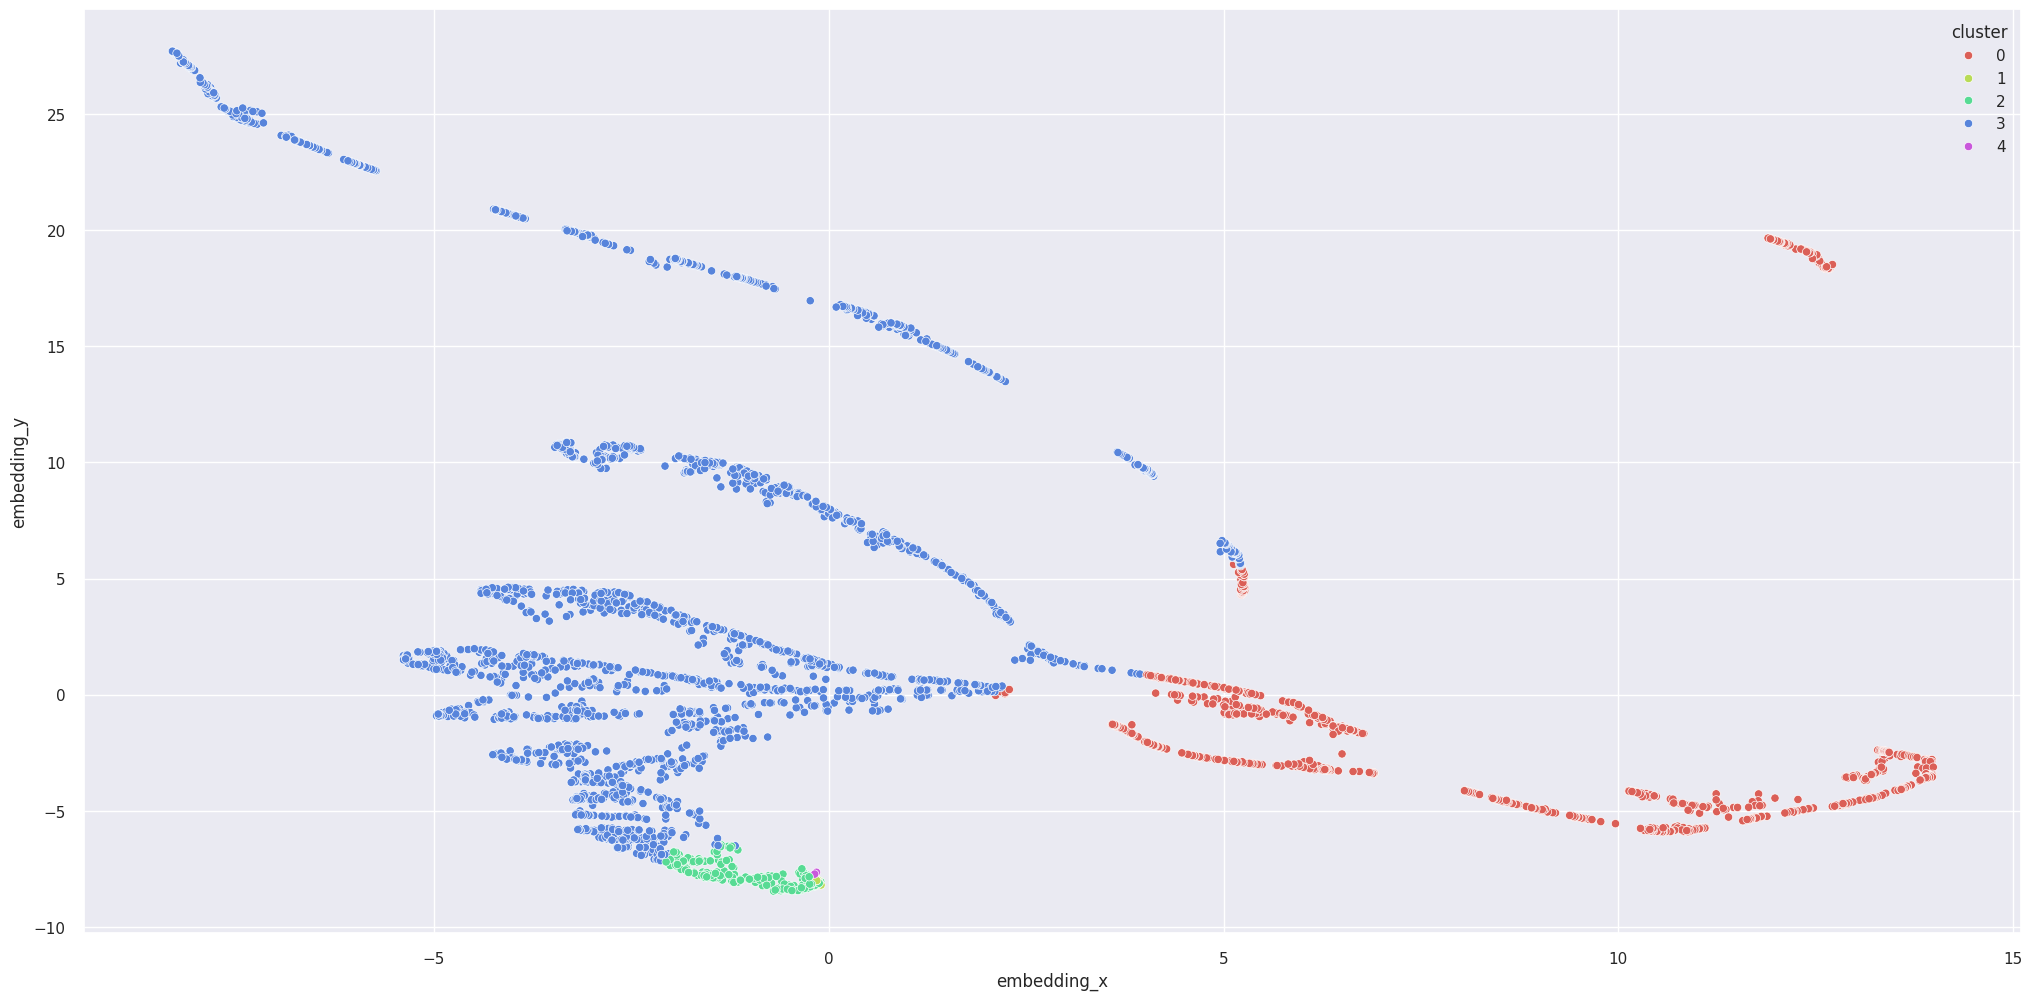

In [41]:
# pip install umap-learn

reducer = umap.UMAP( n_neighbors=50, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz );

## 9.4 Cluster Profile

In [42]:
# Number of customer
df_cluster = df9[['cluster', 'customer_id']].groupby( 'cluster').count().reset_index().rename( columns = { 'customer_id' : 'count' } )
df_cluster['perc_customer'] = round( df_cluster['count'] / df_cluster['count'].sum() * 100, 2)

# Average Recency Days
df_cluster_recency = df9[['cluster', 'recency_days']].groupby( 'cluster').mean().reset_index()
df_cluster_recency['recency_days'] = round( df_cluster_recency['recency_days'], 2)

# Average Purchase Frequeccy
df_cluster_frequency = df9[['cluster', 'invoice_no']].groupby( 'cluster').mean().reset_index()
df_cluster_frequency['invoice_no'] = round( df_cluster_frequency['invoice_no'], 2)

# Average Gross Revenue
df_cluster_monetary = df9[['cluster', 'gross_revenue']].groupby( 'cluster').mean().reset_index()
df_cluster_monetary['gross_revenue'] = round( df_cluster_monetary['gross_revenue'], 2)

# Average Ticket
df_cluster_ticket = df9[['cluster', 'avg_ticket']].groupby( 'cluster').mean().reset_index()
df_cluster_ticket['avg_ticket'] = round( df_cluster_ticket['avg_ticket'], 2)

# Merging datasets
df_cluster = pd.merge( df_cluster, df_cluster_recency,   how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_frequency, how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_monetary,  how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_ticket,    how='inner', on='cluster' )
df_cluster.head()


,cluster,count,perc_customer,recency_days,invoice_no,gross_revenue,avg_ticket
0,0,1064,24.57,1.56,-0.35,-0.17,-0.02
1,1,12,0.28,-0.85,11.03,13.52,0.07
2,2,208,4.80,-0.79,2.34,1.11,0.05
3,3,3044,70.30,-0.49,-0.08,-0.08,-0.03
4,4,2,0.05,0.70,-0.36,13.53,45.33
